In [103]:
from sklearn.datasets import  make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.linear_model import RidgeClassifier
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector

# Generate synthetic one modal dataset

In [104]:
X, y = make_blobs(n_samples=2502, centers=2, n_features=2, random_state=259202)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=259202)

In [105]:
X_train, y_train

(array([[ 1.74771932,  7.06026374],
        [11.63628313,  2.43832222],
        [ 7.83213125,  3.25616202],
        ...,
        [11.15319987,  2.83310227],
        [ 0.365067  ,  5.57690838],
        [11.17654856,  2.5515603 ]], shape=(2001, 2)),
 array([0, 1, 1, ..., 1, 0, 1], shape=(2001,)))

In [106]:
X_test.shape, y_test.shape

((501, 2), (501,))

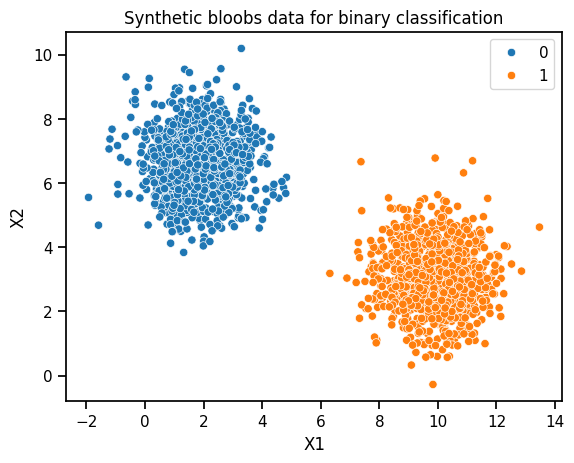

In [107]:
def plot_2d_data(X, y, title):
    sns.set_context("notebook")
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.show()
plot_2d_data(X_train, y_train, "Synthetic bloobs data for binary classification")

Normalize the data

In [108]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

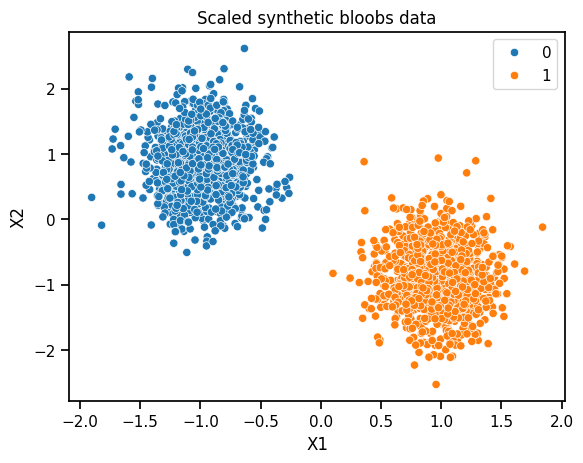

In [109]:
plot_2d_data(X_train, y_train, "Scaled synthetic bloobs data")

Moons dataset

In [110]:
X_moons, y_moons = make_moons(n_samples=2502, random_state=259202)
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons,y_moons, test_size=0.2, random_state=259202)

In [111]:
X_moons_train.shape, y_moons_train.shape

((2001, 2), (2001,))

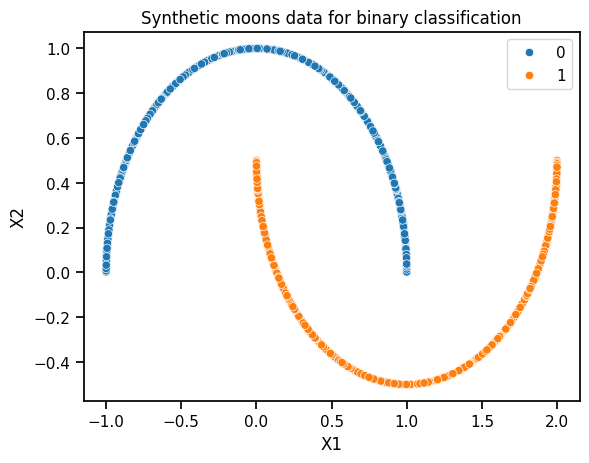

In [112]:
plot_2d_data(X_moons_train, y_moons_train, "Synthetic moons data for binary classification")

In [113]:
scaler_moons = StandardScaler()
X_moons_train = scaler_moons.fit_transform(X_moons_train)
X_moons_test = scaler_moons.transform(X_moons_test)

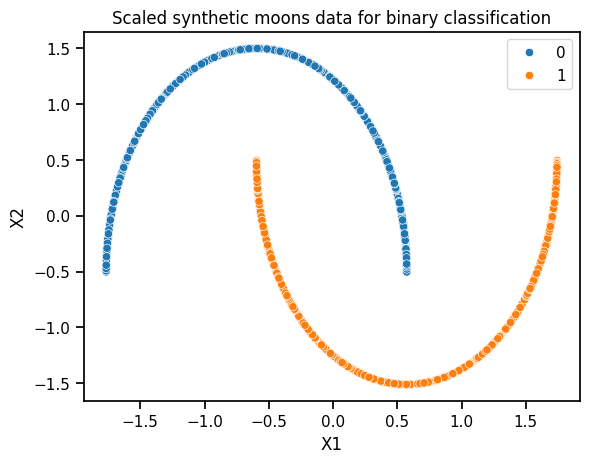

In [114]:
plot_2d_data(X_moons_train, y_moons_train, "Scaled synthetic moons data for binary classification")

# Analytical linear classifier with L2 regularization

In [115]:
def analytical_linear_l2(X, y, lambda_):

    X_ = np.c_[np.ones(X.shape[0]), X] # [N, D+1]

    I = np.eye(X_.shape[1]) # [D+1, D+1]
    I_ = I*lambda_
    
    # (D+1, N) @ (N, D+1) = (D+1, D+1)  <- X_.T @ X_
    # (D+1, D+1) @ (D+1, N) = (D+1, N)  <- inv(X_.T @ X_ + I_) @ X_.T
    # (D+1, N) @ (N, 1) = (D+1, 1)      <- X_.T @ y
    w = np.linalg.inv(X_.T @ X_ + I_) @ X_.T @ y
    return w

In [116]:
w = analytical_linear_l2(X_train, y_train, 1)

In [117]:
w.shape, w

((3,), array([ 0.5014985 ,  0.41123909, -0.08663209]))

In [118]:
X_test_ = np.c_[np.ones(X_test.shape[0]), X_test]
X_test_.shape, X_test_

((501, 3),
 array([[ 1.        ,  0.8355693 , -0.99349447],
        [ 1.        , -1.45735918,  1.09345574],
        [ 1.        , -0.96687053,  0.44704932],
        ...,
        [ 1.        , -1.12383436,  0.80544164],
        [ 1.        ,  1.14406207, -1.31397891],
        [ 1.        , -0.88148021,  0.72198783]], shape=(501, 3)))

In [119]:
scores = X_test_ @ w
scores.shape, scores[:5] , X_test_[:5]

((501,),
 array([ 0.93118576, -0.19255291,  0.06515473,  1.02054516,  0.21864988]),
 array([[ 1.        ,  0.8355693 , -0.99349447],
        [ 1.        , -1.45735918,  1.09345574],
        [ 1.        , -0.96687053,  0.44704932],
        [ 1.        ,  1.18110244, -0.38474391],
        [ 1.        , -0.40260687,  1.35378172]]))

In [120]:
# important to choose the right threshold for scores
y_pred = np.where(scores > 0, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7425


Choose the best lambda

In [121]:
best_w = None
best_l = None
best_acc = 0
for l in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
    w = analytical_linear_l2(X_train, y_train, l)
    scores = np.c_[np.ones(X_test.shape[0]), X_test] @ w
    y_pred = np.where(scores > 0.5, 1, 0)
    accuracy = np.mean(y_pred == y_test)
    print(f"Lambda={l}, Accuracy: {accuracy:.4f}")
    if accuracy > best_acc:
        best_w = w
        best_l = l
w = best_w
l = best_l

Lambda=0.01, Accuracy: 1.0000
Lambda=0.05, Accuracy: 1.0000
Lambda=0.1, Accuracy: 1.0000
Lambda=0.5, Accuracy: 1.0000
Lambda=1.0, Accuracy: 1.0000
Lambda=5.0, Accuracy: 1.0000
Lambda=10.0, Accuracy: 1.0000
Lambda=50.0, Accuracy: 1.0000
Lambda=100.0, Accuracy: 1.0000


Choose the best threshold

In [122]:
best_s = None
best_acc = 0
for s in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    w = analytical_linear_l2(X_train, y_train, 1)
    scores = np.c_[np.ones(X_test.shape[0]), X_test] @ w
    y_pred = np.where(scores > s, 1, 0)
    accuracy = np.mean(y_pred == y_test)
    print(f"Score thrs={s}, Accuracy: {accuracy:.4f}")
    if accuracy > best_acc:
        best_s = s
        best_acc = accuracy
        
s = best_s
accuracy = best_acc

Score thrs=0.01, Accuracy: 0.7505
Score thrs=0.05, Accuracy: 0.8164
Score thrs=0.1, Accuracy: 0.8882
Score thrs=0.5, Accuracy: 1.0000
Score thrs=1.0, Accuracy: 0.7026
Score thrs=5.0, Accuracy: 0.5070


Make the predictions

In [123]:
scores = X_test_ @ w
y_pred = np.where(scores > 0.5, 1 ,0)

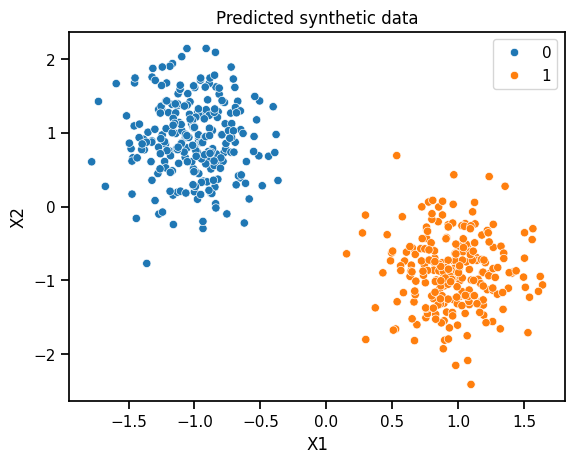

In [124]:
plot_2d_data(X_test, y_pred, "Predicted synthetic data")

In [125]:
def plot_decision_boundary(w, X, y):
    
    # mesh grid
    h = 0.02 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # decision function
    Z = w[0] + w[1] * xx + w[2] * yy
    Z = Z.reshape(xx.shape)
    
    # print("Z:", Z, Z.shape)
    
    plt.figure(figsize=(8, 6))
    
    # decision boundary
    plt.contourf(xx, yy, Z > 0.5, alpha=0.3)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
        
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Decision boundary analytical")
    plt.show()

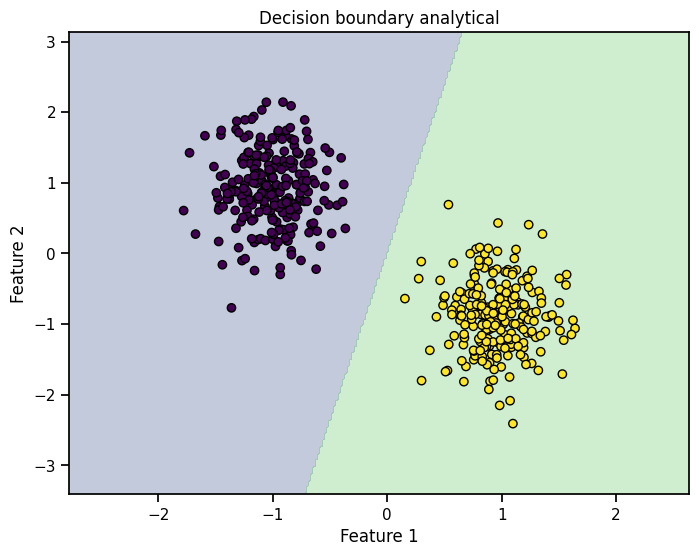

In [126]:
plot_decision_boundary(w, X_test, y_pred)

Confusion matrix analytical

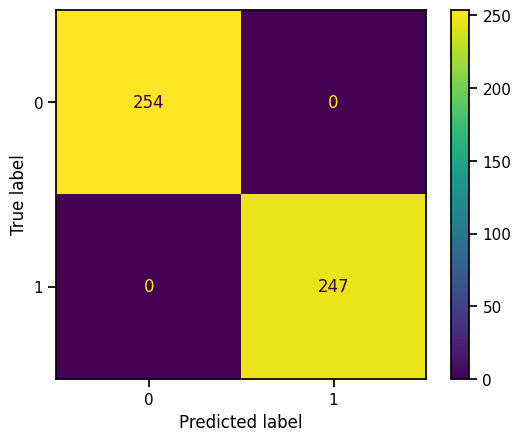

In [127]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [128]:
cr = classification_report(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp) # swoistosc
sensitivity = tp / (tp+fn) # czulosc
print(cr)
print(f"specificity: {specificity}")
print(f"sensitivity: {sensitivity}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       247

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

specificity: 1.0
sensitivity: 1.0


In [129]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc_analytical = auc(fpr, tpr)


print(f"fpr: {fpr}")
print(f"tpr: {tpr}") 
print(f"thresholds: {thresholds}") 

fpr: [0. 0. 0. 1.]
tpr: [0.         0.00404858 1.         1.        ]
thresholds: [        inf  1.27891983  0.6204122  -0.33270952]


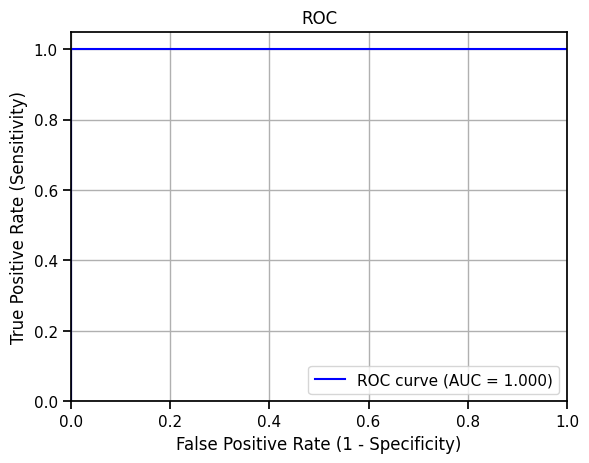

In [130]:
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc(fpr, tpr):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Moons dataset

In [131]:
w_moons = analytical_linear_l2(X_moons_train, y_moons_train, 1)

In [132]:
w_moons.shape, w_moons

((3,), array([ 0.5014985 ,  0.13284339, -0.33269303]))

In [133]:
X_moons_test_ = np.c_[np.ones(X_moons_test.shape[0]), X_moons_test]
X_moons_test_.shape, X_moons_test.shape

((501, 3), (501, 2))

In [134]:
scores_moons = X_moons_test_ @ w_moons
scores_moons.shape, scores_moons[:5]

((501,), array([0.49542991, 0.38758819, 1.07528834, 0.22676626, 1.05598043]))

In [135]:
y_moons_pred = np.where(scores_moons < 0.5, 0, 1)

accuracy_moons = accuracy_score(y_moons_test, y_moons_pred)
print(f"Accuracy moons: {accuracy_moons:.4f}")

Accuracy moons: 0.8862


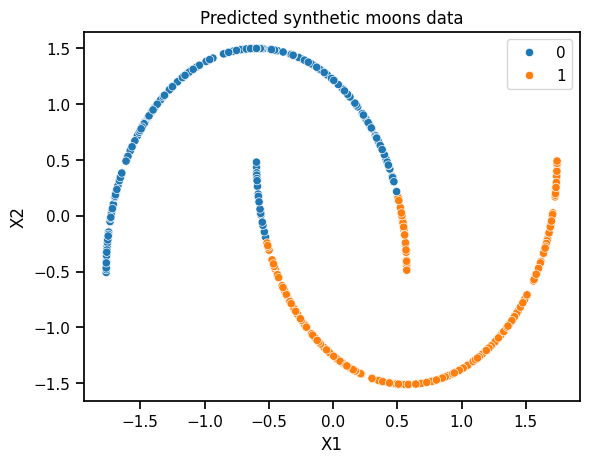

In [136]:
plot_2d_data(X_moons_test, y_moons_pred, "Predicted synthetic moons data")

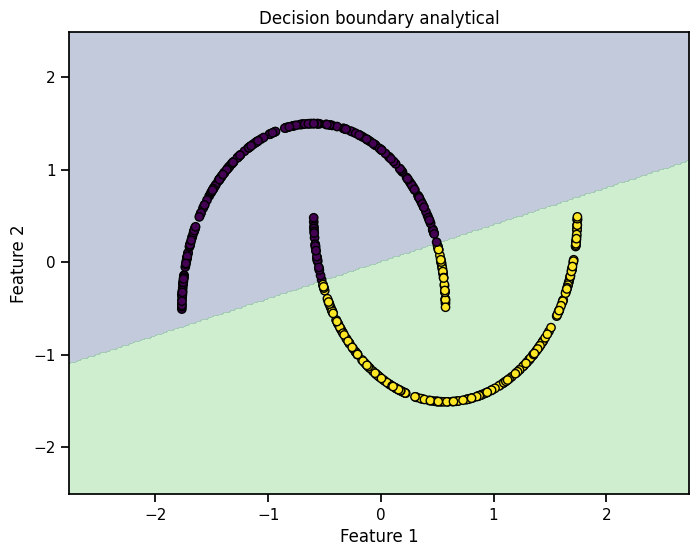

In [137]:
plot_decision_boundary(w_moons, X_moons_test, y_moons_pred)

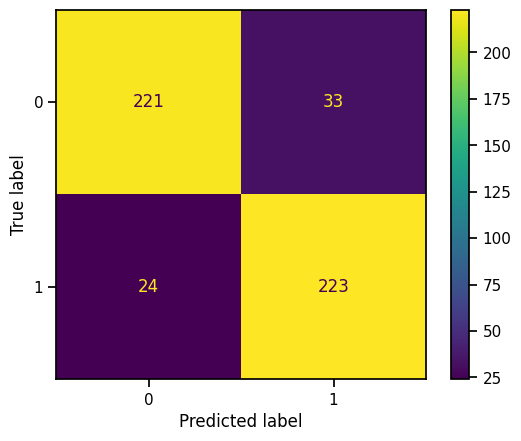

In [138]:
cm_moons = confusion_matrix(y_moons_test, y_moons_pred)
disp_moons = ConfusionMatrixDisplay(confusion_matrix=cm_moons)
disp_moons.plot()
plt.show()

In [139]:
cr_moons = classification_report(y_moons_test, y_moons_pred)
tn, fp, fn, tp = cm_moons.ravel()
specificity_moons = tn / (tn+fp) # swoistosc
sensitivity_moons = tp / (tp+fn) # czulosc
print(cr_moons)
print(f"specificity: {specificity_moons}")
print(f"sensitivity: {sensitivity_moons}")

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       254
           1       0.87      0.90      0.89       247

    accuracy                           0.89       501
   macro avg       0.89      0.89      0.89       501
weighted avg       0.89      0.89      0.89       501

specificity: 0.8700787401574803
sensitivity: 0.902834008097166


In [140]:
fpr_moons, tpr_moons, thresholds_moons = roc_curve(y_moons_test, scores_moons)
auc_analytical_moons = auc(fpr_moons, tpr_moons)


print(f"fpr: {fpr_moons}")
print(f"tpr: {tpr_moons}") 
print(f"thresholds: {thresholds_moons}") 

fpr: [0.         0.         0.         0.00393701 0.00393701 0.00787402
 0.00787402 0.01574803 0.01574803 0.02362205 0.02362205 0.03937008
 0.03937008 0.04330709 0.04330709 0.04724409 0.04724409 0.05511811
 0.05511811 0.05905512 0.05905512 0.06299213 0.06299213 0.06692913
 0.06692913 0.07086614 0.07086614 0.07480315 0.07480315 0.07874016
 0.07874016 0.08267717 0.08267717 0.09448819 0.09448819 0.10629921
 0.10629921 0.11417323 0.11417323 0.11811024 0.11811024 0.12992126
 0.12992126 0.13385827 0.13385827 0.14173228 0.14173228 0.1496063
 0.1496063  0.16535433 0.16535433 0.17322835 0.17322835 0.17716535
 0.17716535 0.18897638 0.18897638 0.21259843 0.21259843 0.23228346
 0.23228346 0.23622047 0.23622047 0.24015748 0.24015748 0.27559055
 0.27559055 0.29527559 0.29527559 0.31496063 0.31496063 0.31889764
 0.31889764 0.33464567 0.33464567 0.3503937  0.3503937  1.        ]
tpr: [0.         0.00404858 0.67611336 0.67611336 0.68825911 0.68825911
 0.70040486 0.70040486 0.70445344 0.70445344 0.72469

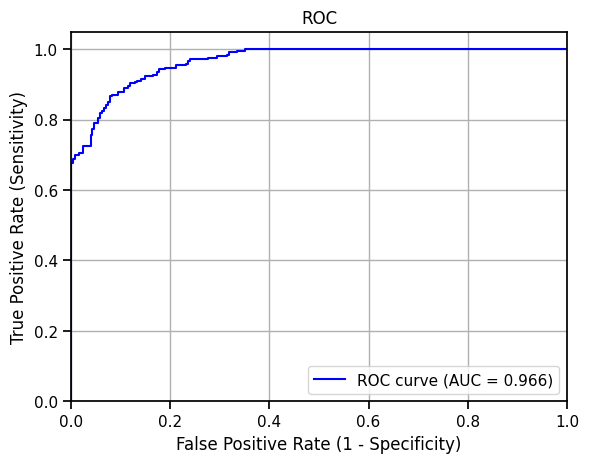

In [141]:
plt.plot(fpr_moons, tpr_moons, color='blue', label=f'ROC curve (AUC = {auc(fpr_moons, tpr_moons):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

As we can see accuracy, roc and all metrics in moons dataset are worse in linear classifier, because you cannot classify correctly moon shapes with a line.

# Sklearn Ridge Classifier

In [142]:
# model training
clf = RidgeClassifier(alpha=3.0).fit(X_train, y_train) # alpha controls the regularization strength of the model

In [143]:
y_pred_sklearn = clf.predict(X_test)
scores_sklearn = clf.decision_function(X_test)
y_pred_sklearn[:5], scores_sklearn[:5]

(array([1, 0, 0, 1, 0]),
 array([ 0.86271618, -1.38314579, -0.86770518,  1.03947938, -0.5637464 ]))

In [144]:
accuracy_sklearn = clf.score(X_test, y_test)
print(f"RidgeClassifier accuracy: {accuracy_sklearn:.4f}")

RidgeClassifier accuracy: 1.0000


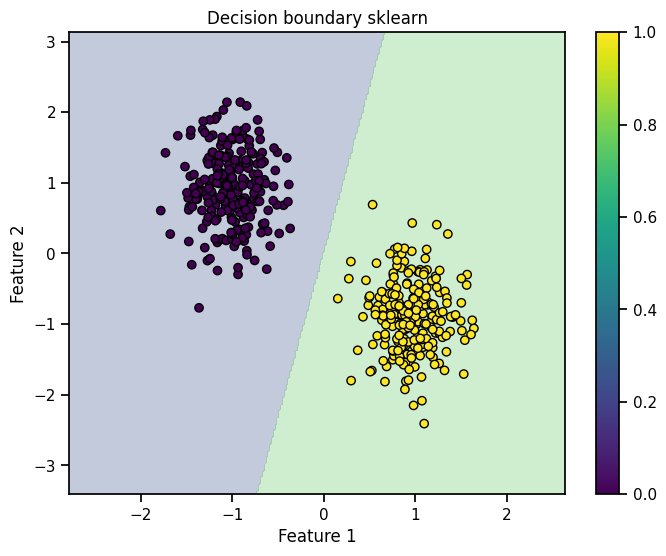

In [145]:
def plot_decision_boundary_ridge(clf, X, y):

    h = 0.02 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    
    plt.contourf(xx, yy, Z > 0, alpha=0.3)
        
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Decision boundary sklearn")
    plt.colorbar(scatter)
    plt.show()

plot_decision_boundary_ridge(clf, X_test, y_test)

Confusion matrix sklearn

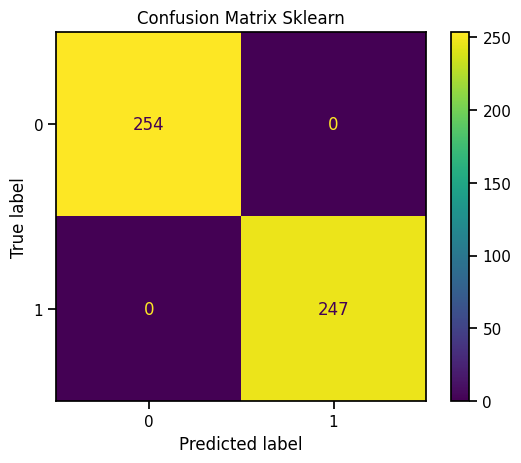

In [146]:
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn)
disp.plot()
plt.title("Confusion Matrix Sklearn")
plt.show()

Classification raport

In [147]:
cr_sklearn = classification_report(y_test, y_pred_sklearn)
tn, fp, fn, tp = cm_sklearn.ravel()
specificity_sklearn = tn / (tn+fp)  # swoistość
sensitivity_sklearn = tp / (tp+fn)  # czułość
print(cr_sklearn)
print(f"Specificity: {specificity_sklearn}")
print(f"Sensitivity: {sensitivity_sklearn}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       247

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Specificity: 1.0
Sensitivity: 1.0


ROC Curve

In [148]:
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, scores_sklearn)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

print(f"fpr: {fpr_sklearn}")
print(f"tpr: {tpr_sklearn}") 
print(f"thresholds: {thresholds_sklearn}") 

fpr: [0. 0. 0. 1.]
tpr: [0.         0.00404858 1.         1.        ]
thresholds: [        inf  1.55784358  0.24214004 -1.66342595]


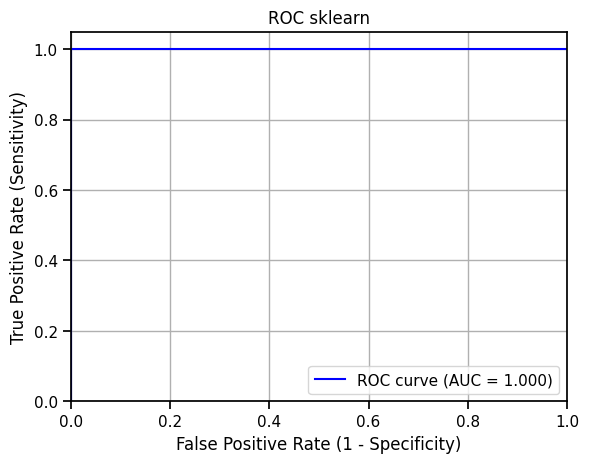

In [149]:
plt.plot(fpr_sklearn, tpr_sklearn, color='blue', label=f'ROC curve (AUC = {auc(fpr_sklearn, tpr_sklearn):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC sklearn')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Moons dataset

In [150]:
clf_moons = RidgeClassifier(alpha=3.0).fit(X_moons_train, y_moons_train)

In [151]:
y_moons_pred_sklearn = clf_moons.predict(X_moons_test)
scores_moons_sklearn = clf_moons.decision_function(X_moons_test)
y_moons_pred_sklearn[:5], scores_moons_sklearn[:5]

(array([0, 0, 1, 0, 1]),
 array([-0.00879598, -0.22395415,  1.150067  , -0.54532598,  1.11145603]))

In [152]:
accuracy_moons_sklearn = clf_moons.score(X_moons_test, y_moons_test)
print(f"RidgeClassifier moons accuracy: {accuracy_moons_sklearn:.4f}")

RidgeClassifier moons accuracy: 0.8862


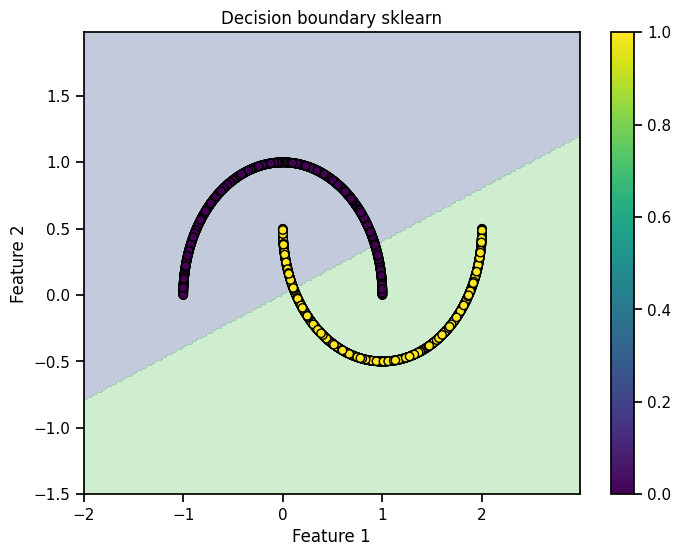

In [153]:
plot_decision_boundary_ridge(clf_moons, X_moons, y_moons)

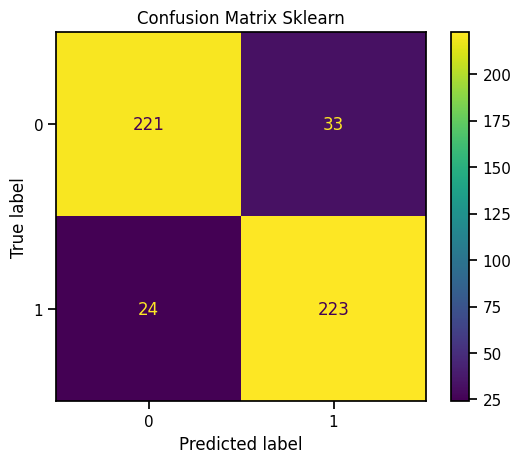

In [154]:
cm_moons_sklearn = confusion_matrix(y_moons_test, y_moons_pred_sklearn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_moons_sklearn)
disp.plot()
plt.title("Confusion Matrix Sklearn")
plt.show()

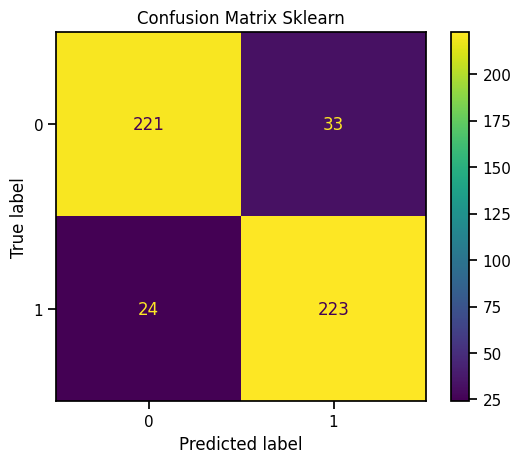

In [155]:
cm_moons_sklearn = confusion_matrix(y_moons_test, y_moons_pred_sklearn)
disp.plot()
plt.title("Confusion Matrix Sklearn")
plt.show()

In [156]:
cr_moons_sklearn = classification_report(y_moons_test, y_moons_pred_sklearn)
tn, fp, fn, tp = cm_moons_sklearn.ravel()
specificity_moons_sklearn = tn / (tn+fp)  # swoistość
sensitivity_moons_sklearn = tp / (tp+fn)  # czułość
print(cr_moons_sklearn)
print(f"Specificity: {specificity_moons_sklearn}")
print(f"Sensitivity: {sensitivity_moons_sklearn}")

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       254
           1       0.87      0.90      0.89       247

    accuracy                           0.89       501
   macro avg       0.89      0.89      0.89       501
weighted avg       0.89      0.89      0.89       501

Specificity: 0.8700787401574803
Sensitivity: 0.902834008097166


In [157]:
fpr_moons_sklearn, tpr_moons_sklearn, thresholds_moons_sklearn = roc_curve(y_moons_test, scores_moons_sklearn)
auc_moons_sklearn = auc(fpr_moons_sklearn, tpr_moons_sklearn)

print(f"fpr: {fpr_moons_sklearn}")
print(f"tpr: {tpr_moons_sklearn}") 
print(f"thresholds: {thresholds_moons_sklearn}") 

fpr: [0.         0.         0.         0.00393701 0.00393701 0.00787402
 0.00787402 0.01574803 0.01574803 0.02362205 0.02362205 0.03937008
 0.03937008 0.04330709 0.04330709 0.04724409 0.04724409 0.05511811
 0.05511811 0.05905512 0.05905512 0.06299213 0.06299213 0.06692913
 0.06692913 0.07086614 0.07086614 0.07480315 0.07480315 0.07874016
 0.07874016 0.08267717 0.08267717 0.09448819 0.09448819 0.10629921
 0.10629921 0.11417323 0.11417323 0.11811024 0.11811024 0.12992126
 0.12992126 0.13385827 0.13385827 0.14173228 0.14173228 0.1496063
 0.1496063  0.16535433 0.16535433 0.17322835 0.17322835 0.17716535
 0.17716535 0.18897638 0.18897638 0.21259843 0.21259843 0.23228346
 0.23228346 0.23622047 0.23622047 0.24015748 0.24015748 0.27559055
 0.27559055 0.29527559 0.29527559 0.31496063 0.31496063 0.31889764
 0.31889764 0.33464567 0.33464567 0.3503937  0.3503937  1.        ]
tpr: [0.         0.00404858 0.67611336 0.67611336 0.68825911 0.68825911
 0.70040486 0.70040486 0.70445344 0.70445344 0.72469

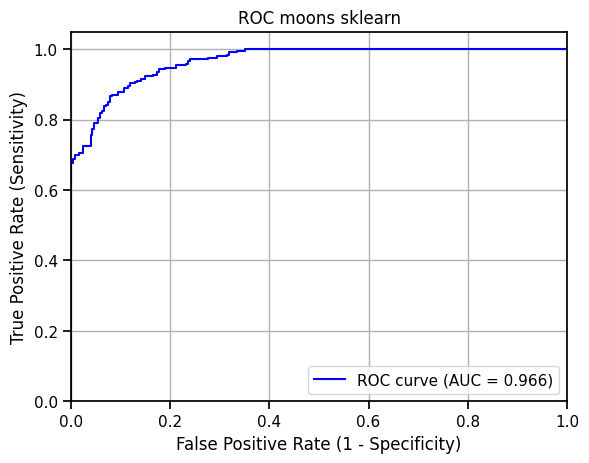

In [158]:
plt.plot(fpr_moons_sklearn, tpr_moons_sklearn, color='blue', label=f'ROC curve (AUC = {auc(fpr_moons_sklearn, tpr_moons_sklearn):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC moons sklearn')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [159]:
start_time = time.time()
for _ in range(1000):
    w = analytical_linear_l2(X_train, y_train, 1)
analytical_time = time.time() - start_time

start_time = time.time()
for _ in range(1000):
    clf = RidgeClassifier().fit(X_train, y_train)
sklearn_time = time.time() - start_time

print(f"Analytical time: {analytical_time:.6f} s")
print(f"Sklearn time: {sklearn_time:.6f} s")

Analytical time: 0.081638 s
Sklearn time: 1.042461 s


In [160]:
comparison_data = {
    'Metric': ['Accuracy blobs', 'Accuracy moons', 'Sensitivity blobs', 'Sensitivity moons', 'Specificity blobs', 'Specificity moons', 'AUC blobs', 'AUC moons', 'Training Time (s)'],
    'Analytical Classifier': [accuracy, accuracy_moons, sensitivity, sensitivity_moons, specificity, specificity_moons, auc_analytical, auc_analytical_moons, analytical_time/1000],
    'RidgeClassifier': [accuracy_sklearn,accuracy_moons_sklearn, sensitivity_sklearn, sensitivity_moons_sklearn, specificity_sklearn, specificity_moons_sklearn, auc_sklearn, auc_moons_sklearn, sklearn_time/1000]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Metric,Analytical Classifier,RidgeClassifier
0,Accuracy blobs,1.000000,1.000000
1,Accuracy moons,0.886228,0.886228
2,Sensitivity blobs,1.000000,1.000000
3,Sensitivity moons,0.902834,0.902834
4,Specificity blobs,1.000000,1.000000
5,Specificity moons,0.870079,0.870079
6,AUC blobs,1.000000,1.000000
7,AUC moons,0.966033,0.966049
8,Training Time (s),0.000082,0.001042


# Heart disease

In [161]:
from ucimlrepo import fetch_ucirepo 

heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [162]:
X.shape, y.shape

((303, 13), (303, 1))

In [163]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [164]:
y = y.iloc[:,0] # y appears to be a DataFrame rather than a Series.

In [165]:
y.shape

(303,)

Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

In [166]:
y.unique()

array([0, 2, 1, 3, 4])

In [167]:
y = y.replace([2,3,4],1)
y.unique(), y.shape

(array([0, 1]), (303,))

In [168]:
nan_count = X.isnull().sum().sum()
print('Number of NaN values:', nan_count)

Number of NaN values: 6


Remove all rows with empty data

In [169]:
data = pd.concat([X, y], axis=1)

data_ = data.dropna()

X_ = data_.iloc[:, :-1] 
y_ = data_.iloc[:, -1]     # last col

X.shape, X_.shape

((303, 13), (297, 13))

sex -> 1 = male

In [170]:
stds = X_.std(axis=0)
min_val = X_.min()
max_val = X_.max()

# 1 -> int, 0 -> Categorical
types = [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]
modes_means = [float(X_[col].mean()) if types[i]==1 else float(X_[col].mode().iloc[0]) for i, col in enumerate(X_)]

In [171]:
stats_df = pd.DataFrame({
    'Type': ['Numeric' if types[i]==1 else 'Categorical' for i in range(len(X_.columns))],
    'Mean/Mode': [X_[col].mean() if types[i]==1 else X_[col].mode().iloc[0] for i, col in enumerate(X_.columns)],
    'Std Dev': [X_[col].std() if types[i]==1 else 'N/A' for i, col in enumerate(X_.columns)],
    'Min': X_.min(),
    'Max': X_.max()
})
stats_df

,Type,Mean/Mode,Std Dev,Min,Max
age,Numeric,54.542088,9.049736,29.0,77.0
sex,Categorical,1.000000,N/A,0.0,1.0
cp,Categorical,4.000000,N/A,1.0,4.0
trestbps,Numeric,131.693603,17.762806,94.0,200.0
chol,Numeric,247.350168,51.997583,126.0,564.0
fbs,Categorical,0.000000,N/A,0.0,1.0
restecg,Categorical,0.000000,N/A,0.0,2.0
thalach,Numeric,149.599327,22.941562,71.0,202.0
exang,Categorical,0.000000,N/A,0.0,1.0
oldpeak,Numeric,1.055556,1.166123,0.0,6.2


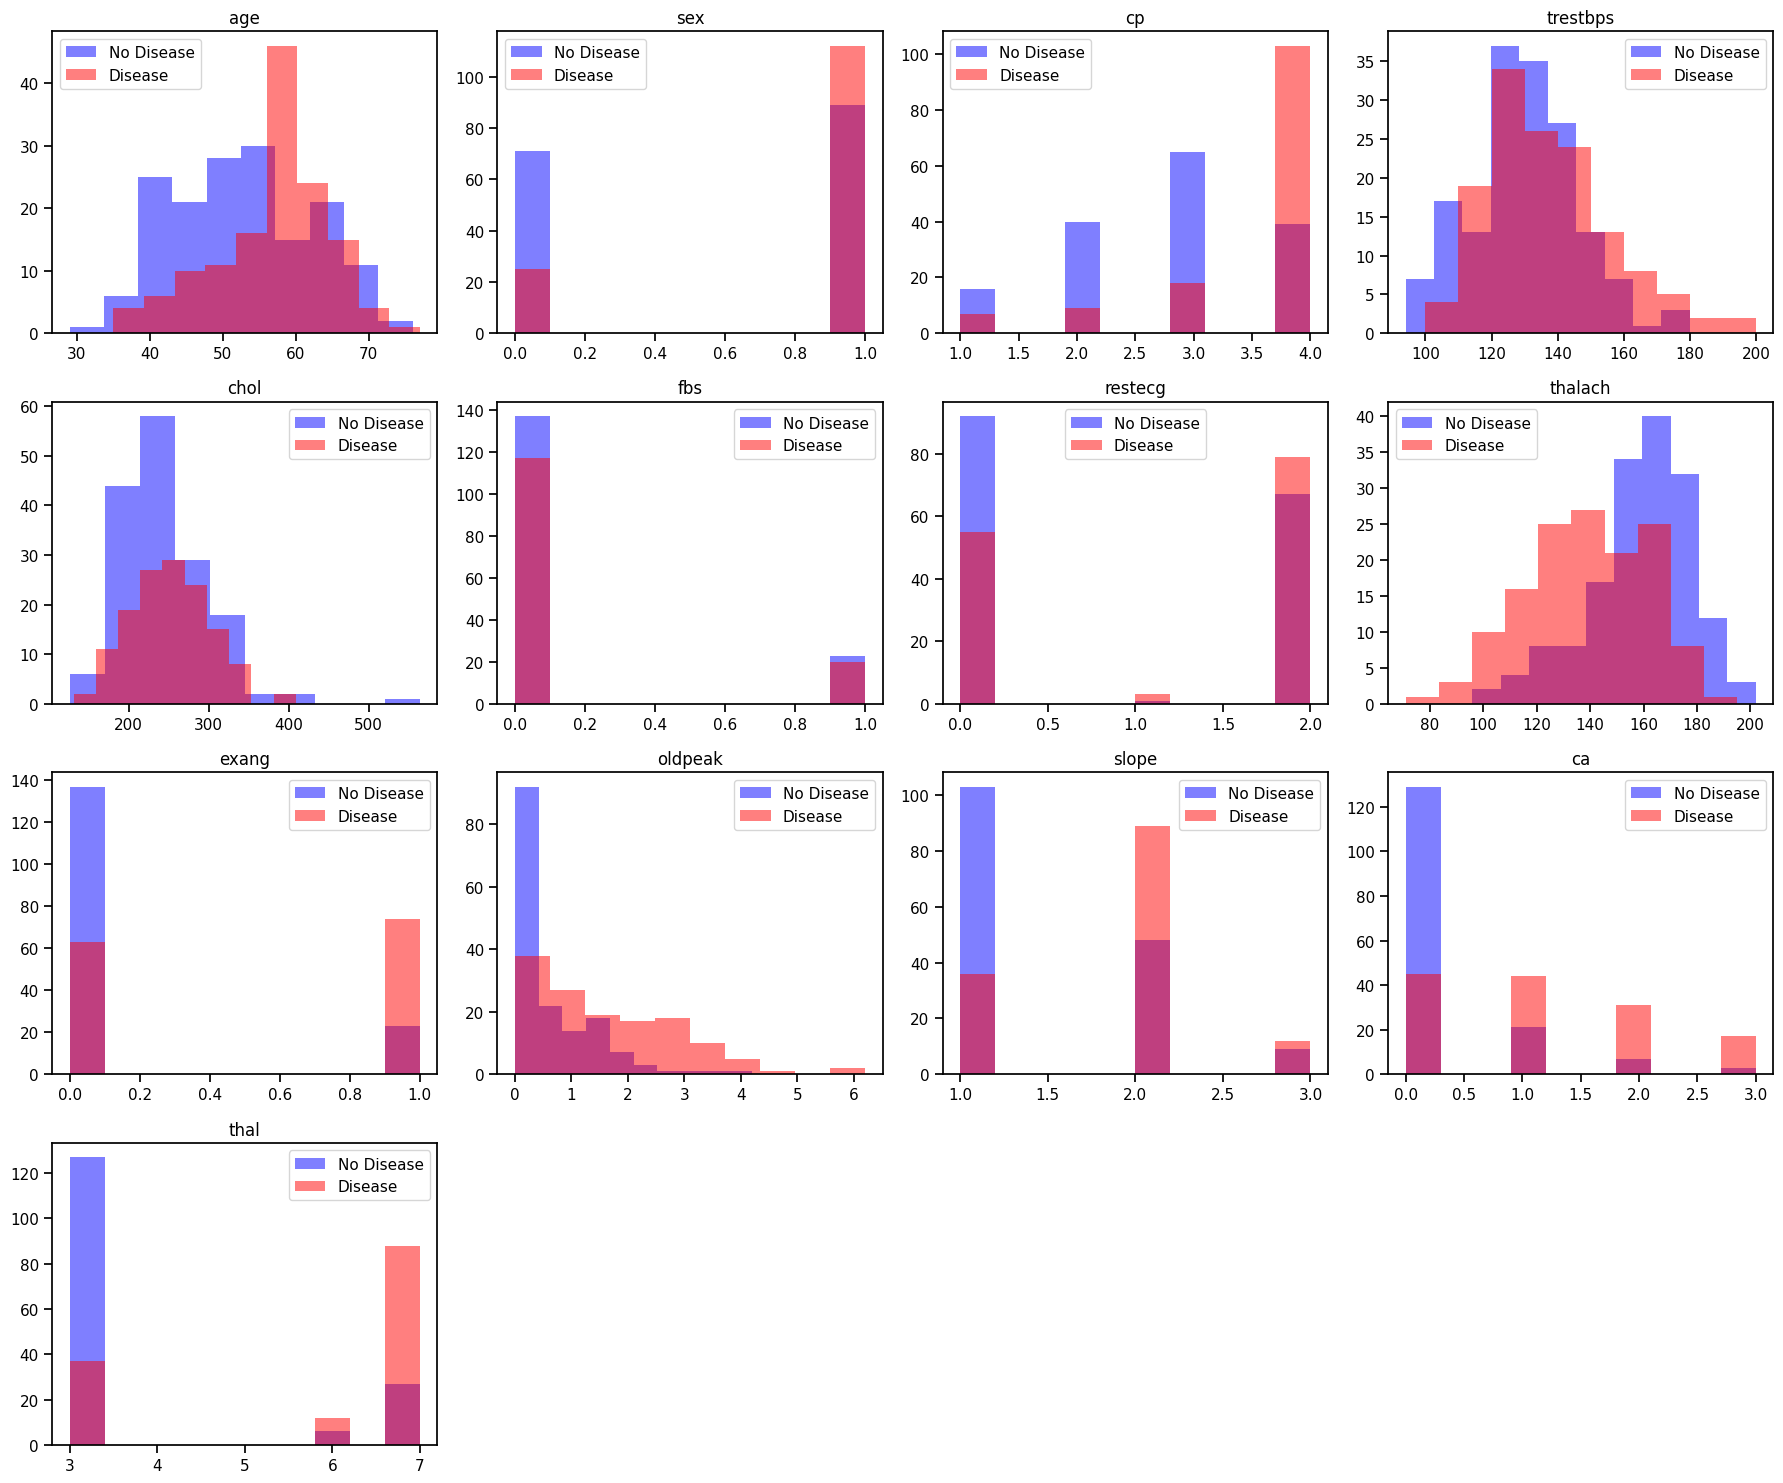

In [172]:
plt.figure(figsize=(18, 15))

for i, column in enumerate(X_.columns):
    plt.subplot(4, 4, i+1)
    for y in [0, 1]:
            subset = X_[y_ == y]
            plt.hist(subset[column], alpha=0.5, 
                     label=f'No Disease' if y == 0 else 'Disease',
                     color='blue' if y == 0 else 'red')
    plt.title(column)
    plt.legend()
    
plt.tight_layout()
plt.show()


Choosing data from histogram means looking for minimal overlap in predicted classes.

We can clearly see in the **age** feature that diseases skyrockets from the age of 60.

**Thalach** is a good candidate as we can also see not overlaping values.

In categorical features we should look for most differences in height of bars in class. Thus **cp**, **ca** and **thal** have a potential to be most influential.

In [184]:
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_, y_, test_size=0.2, random_state=259202)

In [185]:
X_corr = X_train_heart.copy()

X_corr['target'] = y_train_heart.values


corr_matrix = X_corr.corr()
corr_matrix

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.056745,0.123916,0.274371,0.182495,0.171529,0.181130,-0.403644,0.176795,0.187592,0.131047,0.404015,0.140608,0.248073
sex,-0.056745,1.000000,0.008731,-0.036637,-0.160795,0.021544,0.048755,-0.050157,0.125380,0.095940,0.017221,0.078676,0.361026,0.260000
cp,0.123916,0.008731,1.000000,-0.007797,0.063198,-0.057748,0.088317,-0.373749,0.391698,0.172268,0.176365,0.204482,0.307509,0.400378
trestbps,0.274371,-0.036637,-0.007797,1.000000,0.140568,0.204936,0.173511,-0.065351,0.078184,0.193570,0.119271,0.114933,0.153244,0.178151
chol,0.182495,-0.160795,0.063198,0.140568,1.000000,0.019818,0.179915,-0.009764,0.097797,0.096664,0.029808,0.116675,0.055199,0.100001
fbs,0.171529,0.021544,-0.057748,0.204936,0.019818,1.000000,0.108948,-0.034648,0.025397,0.003700,0.047385,0.158561,0.070308,0.030259
restecg,0.181130,0.048755,0.088317,0.173511,0.179915,0.108948,1.000000,-0.094043,0.104156,0.135355,0.159529,0.175043,0.062622,0.229572
thalach,-0.403644,-0.050157,-0.373749,-0.065351,-0.009764,-0.034648,-0.094043,1.000000,-0.389278,-0.302498,-0.367015,-0.237624,-0.243102,-0.402908
exang,0.176795,0.125380,0.391698,0.078184,0.097797,0.025397,0.104156,-0.389278,1.000000,0.250297,0.251477,0.157199,0.328474,0.435951
oldpeak,0.187592,0.095940,0.172268,0.193570,0.096664,0.003700,0.135355,-0.302498,0.250297,1.000000,0.578386,0.250513,0.336435,0.418535


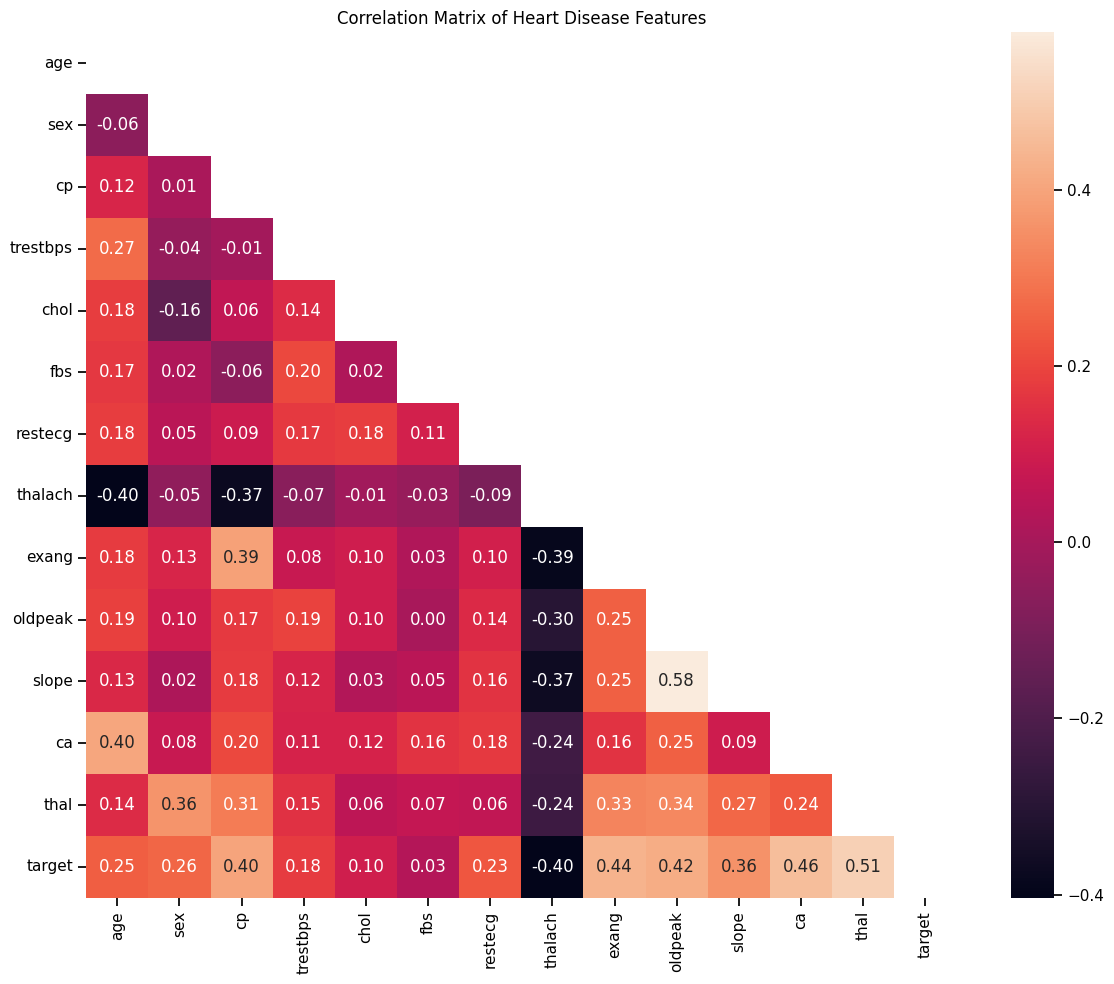

In [186]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f')

plt.title('Correlation Matrix of Heart Disease Features') # add y
plt.tight_layout()
plt.show()

From the correlation matrix we should exclue **thalach**, because its strongly correlated with other featues.

In [176]:
scaler_heart = StandardScaler()
X_train_heart_ = scaler_heart.fit_transform(X_train_heart)
X_test_heart_ = scaler_heart.transform(X_test_heart)

13 features

In [177]:
ridge_all_features = RidgeClassifier(alpha=1.0)
ridge_all_features.fit(X_train_heart_, y_train_heart)
y_pred_ridge_all = ridge_all_features.predict(X_test_heart_)
scores_ridge_all = ridge_all_features.decision_function(X_test_heart_)

accuracy_ridge_all = accuracy_score(y_test_heart, y_pred_ridge_all)
cm_ridge_all = confusion_matrix(y_test_heart, y_pred_ridge_all)
tn, fp, fn, tp = cm_ridge_all.ravel()
specificity_ridge_all = tn / (tn + fp)
sensitivity_ridge_all = tp / (tp + fn)
auc_ridge_all = roc_auc_score(y_test_heart, scores_ridge_all)

In [178]:
X_train_heart_bias = np.c_[np.ones(X_train_heart_.shape[0]), X_train_heart_]
X_train_heart_bias = np.c_[np.ones(X_test_heart_.shape[0]), X_test_heart_]

w_heart_all = analytical_linear_l2(X_train_heart_, y_train_heart, 1.0)
scores_analytical_all = X_train_heart_bias @ w_heart_all
y_pred_analytical_all = np.where(scores_analytical_all > 0.5, 1, 0)

accuracy_analytical_all = accuracy_score(y_test_heart, y_pred_analytical_all)
cm_analytical_all = confusion_matrix(y_test_heart, y_pred_analytical_all)
tn, fp, fn, tp = cm_analytical_all.ravel()
specificity_analytical_all = tn / (tn + fp)
sensitivity_analytical_all = tp / (tp + fn)
auc_analytical_all = roc_auc_score(y_test_heart, scores_analytical_all)

In [179]:
print(f"RidgeClassifier: Accuracy={accuracy_ridge_all:.4f}, Sensitivity={sensitivity_ridge_all:.4f}, Specificity={specificity_ridge_all:.4f}, AUC={auc_ridge_all:.4f}")
print(f"Analytical: Accuracy={accuracy_analytical_all:.4f}, Sensitivity={sensitivity_analytical_all:.4f}, Specificity={specificity_analytical_all:.4f}, AUC={auc_analytical_all:.4f}")
print("\nRidgeClassifier:")
print(classification_report(y_test_heart, y_pred_ridge_all))
print("\nAnalytical Classifier:")
print(classification_report(y_test_heart, y_pred_analytical_all))

RidgeClassifier: Accuracy=0.8667, Sensitivity=0.7667, Specificity=0.9667, AUC=0.9178
Analytical: Accuracy=0.8667, Sensitivity=0.7667, Specificity=0.9667, AUC=0.9178

RidgeClassifier:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88        30
           1       0.96      0.77      0.85        30

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60


Analytical Classifier:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88        30
           1       0.96      0.77      0.85        30

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60



In [180]:
# Automatic feature selection
sfs = SequentialFeatureSelector(
    estimator=RidgeClassifier(alpha=1.0),
    n_features_to_select=4,
    direction='forward', # forward selection -> add features
    cv=5 # 5-fold cross-validation (default)
)

sfs.fit(X_train_heart_, y_train_heart) 
selected_features_mask = sfs.get_support() # True/False mask for selected features
selected_features = X_.columns[selected_features_mask].tolist()

print(f"\nAutomatically selected features: {selected_features}")


Automatically selected features: ['cp', 'exang', 'ca', 'thal']


In [ ]:
manual_features = ['age', 'cp', 'ca', 'thal']

Większość cech wybrana automatycznie jest podobna do tych wybranych manualnie.

In [182]:
X_train_auto = X_train_heart_[:, selected_features_mask]
X_test_auto = X_test_heart_[:, selected_features_mask]

manual_features_mask = np.array([col in manual_features for col in X_.columns])
X_train_manual = X_train_heart_[:, manual_features_mask]
X_test_manual = X_test_heart_[:, manual_features_mask]

In [183]:
def evaluate_classifiers(X_train, X_test, y_train, y_test):

    ridge_model = RidgeClassifier(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    scores_ridge = ridge_model.decision_function(X_test)
    

    accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
    cm_ridge = confusion_matrix(y_test, y_pred_ridge)
    tn, fp, fn, tp = cm_ridge.ravel()
    specificity_ridge = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_ridge = tp / (tp + fn) if (tp + fn) > 0 else 0
    auc_ridge = roc_auc_score(y_test, scores_ridge)
    

    X_train_with_bias = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test_with_bias = np.c_[np.ones(X_test.shape[0]), X_test]
    
    w_analytical = analytical_linear_l2(X_train, y_train, 1.0)
    scores_analytical = X_test_with_bias @ w_analytical
    y_pred_analytical = np.where(scores_analytical > 0.5, 1, 0)
    

    accuracy_analytical = accuracy_score(y_test, y_pred_analytical)
    cm_analytical = confusion_matrix(y_test, y_pred_analytical)
    tn, fp, fn, tp = cm_analytical.ravel()
    specificity_analytical = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_analytical = tp / (tp + fn) if (tp + fn) > 0 else 0
    auc_analytical = roc_auc_score(y_test, scores_analytical)
    
    print(f"RidgeClassifier: Accuracy={accuracy_ridge:.4f}, Sensitivity={sensitivity_ridge:.4f}, Specificity={specificity_ridge:.4f}, AUC={auc_ridge:.4f}")
    print(f"Analytical: Accuracy={accuracy_analytical:.4f}, Sensitivity={sensitivity_analytical:.4f}, Specificity={specificity_analytical:.4f}, AUC={auc_analytical:.4f}")
    

print("\nSequentialFeatureSelector")
evaluate_classifiers(X_train_auto, X_test_auto, y_train_heart, y_test_heart)

print("\nManually selected features")
evaluate_classifiers(X_train_manual, X_test_manual, y_train_heart, y_test_heart)


SequentialFeatureSelector
RidgeClassifier: Accuracy=0.8833, Sensitivity=0.8000, Specificity=0.9667, AUC=0.9156
Analytical: Accuracy=0.8833, Sensitivity=0.8000, Specificity=0.9667, AUC=0.9156

Manually selected features
RidgeClassifier: Accuracy=0.8500, Sensitivity=0.7667, Specificity=0.9333, AUC=0.8994
Analytical: Accuracy=0.8500, Sensitivity=0.7667, Specificity=0.9333, AUC=0.8994


As we can see on all 13 features we got accuracy = 0.8667, but on only 4 most important features we got accuracy = 0.8833 with sfs and accuracy = 0.8500.